### Mục đích
 * Tìm khoảng giới hạn a, dưới số lượng a thì không bất thường, trên số lượng a thì bất thường.

In [136]:
import pandas as pd

### Thêm tên cột dành cho tập dataset

### Dữ liệu khảo sát từ ngày 12 tháng 6 đến ngày 17 tháng 7 

In [137]:
col_names = ['time_stamp', 'source', 'message']
# col_names = ['ip_address', 'time_stamp', 'request', 'status_code', 'response_size', 'user_agent']

file_path = '../dataset/access_log_1.csv'
data = pd.read_csv(file_path, header = 0 , names = col_names)

### Quy đổi thời gian


In [138]:
data['time_stamp'] = pd.to_datetime(data['time_stamp'])

In [139]:
data['time_stamp'].value_counts()

2023-06-12 08:15:54.057000+00:00    319
2023-07-13 08:01:10.085000+00:00    177
2023-06-12 08:10:50.127000+00:00    158
2023-06-12 08:15:54.056000+00:00    156
2023-07-13 08:00:56.151000+00:00    152
                                   ... 
2023-06-21 03:11:16.002000+00:00      1
2023-06-21 03:11:16.006000+00:00      1
2023-06-21 03:11:16.013000+00:00      1
2023-06-21 03:11:16.021000+00:00      1
2023-07-19 03:40:36.363000+00:00      1
Name: time_stamp, Length: 863093, dtype: int64

In [140]:
data['date'] = pd.to_datetime(data['time_stamp'])
data['date'] = data['date'].dt.strftime('%d-%m')
data['date'].value_counts()

19-06    271276
22-06    218187
21-06    189996
20-06    183708
30-06    146177
23-06     78288
26-06     44868
12-06     36467
15-06     35323
28-06     32524
27-06     28751
13-07     26643
16-06     26602
07-07      9757
18-07      4468
14-06      2425
17-07      1158
11-07       237
10-07       147
13-06        16
12-07         8
01-07         1
04-07         1
19-07         1
Name: date, dtype: int64

(array([19521., 19525., 19529., 19533., 19537., 19539., 19543., 19547.,
        19551., 19555.]),
 [Text(19521.0, 0, '13-06'),
  Text(19525.0, 0, '17-06'),
  Text(19529.0, 0, '21-06'),
  Text(19533.0, 0, '25-06'),
  Text(19537.0, 0, '29-06'),
  Text(19539.0, 0, '01-07'),
  Text(19543.0, 0, '05-07'),
  Text(19547.0, 0, '09-07'),
  Text(19551.0, 0, '13-07'),
  Text(19555.0, 0, '17-07')])

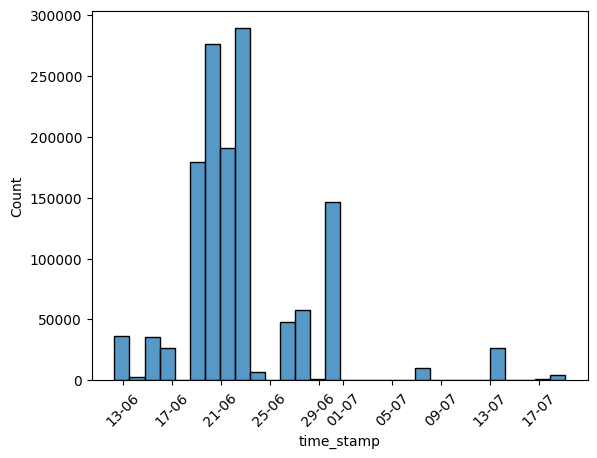

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.histplot(data['time_stamp'], bins = 30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xticks(rotation=45)


### Nhận xét về biểu đồ
* Trong ngày 18 đến ngày 25 tháng 6 có số lượng request tăng đột biến
* Trong khoàng thời gan từ ngày 1 đến ngày 17 tháng 7 số lượng request không có đặc biệt

In [142]:
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin


def find_boxplot_boundaries(
    col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Findx minimum and maximum in boxplot.

    Args:
        col: a pandas serires of input.
        whisker_coeff: whisker coefficient in box plot
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper


class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

In [143]:
class ZscoreOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, z_threshold: float = 3):
        self.z_threshold = z_threshold
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        mean = X.mean()
        std = X.std()
        self.lower = mean - self.z_threshold * std
        self.upper = mean + self.z_threshold * std
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

In [144]:
data['timestamp'] = pd.to_datetime(data['time_stamp'], format='%Y-%m-%d %H:%M:%S.%f%z')
data['timestamp'] = data['timestamp'].dt.strftime('%d-%m')
request_counts_of_day = data['timestamp'].value_counts().to_frame()
print(request_counts_of_day)

       timestamp
19-06     271276
22-06     218187
21-06     189996
20-06     183708
30-06     146177
23-06      78288
26-06      44868
12-06      36467
15-06      35323
28-06      32524
27-06      28751
13-07      26643
16-06      26602
07-07       9757
18-07       4468
14-06       2425
17-07       1158
11-07        237
10-07        147
13-06         16
12-07          8
01-07          1
04-07          1
19-07          1


### Ý Tưởng I: Tần suất về tổng số lượng request trong một ngày 

<Axes: ylabel='Density'>

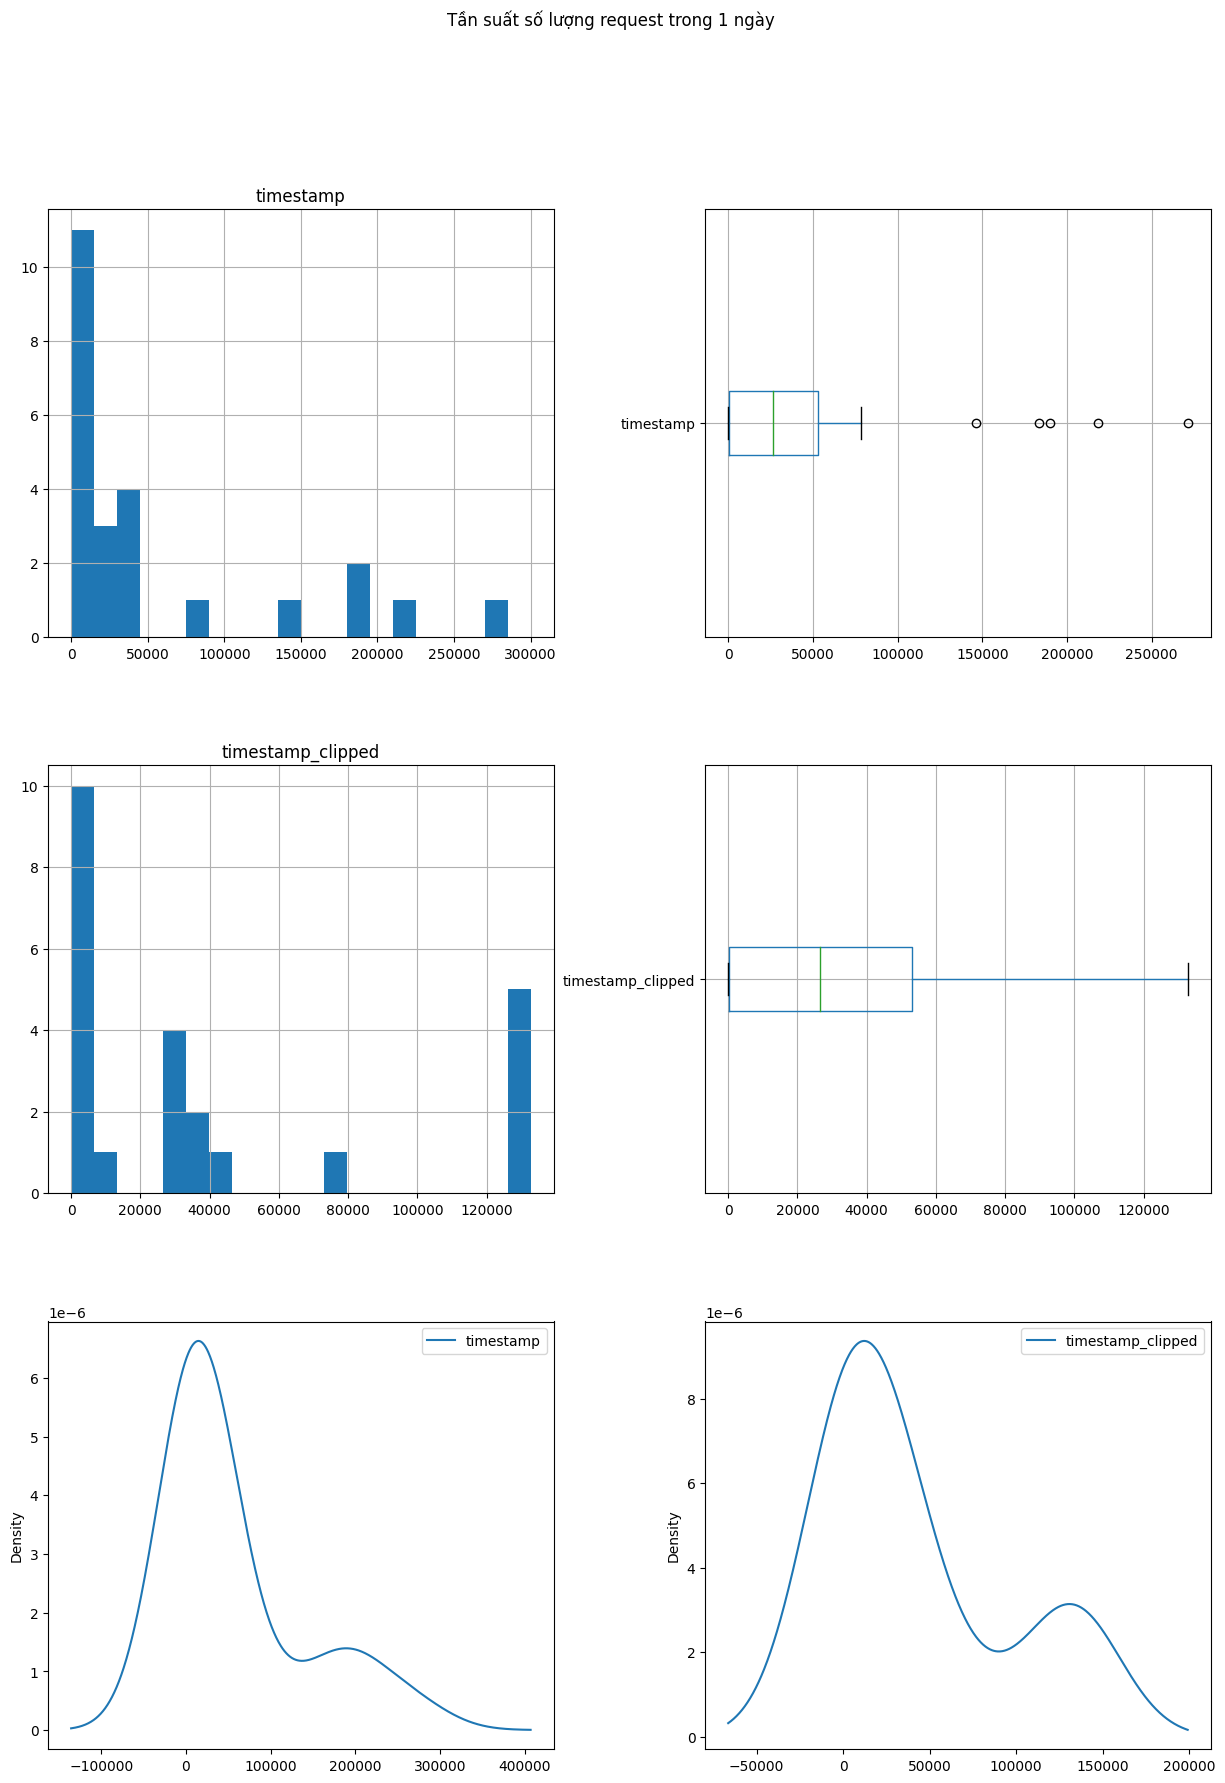

In [145]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
fig.suptitle("Tần suất số lượng request trong 1 ngày")

request_counts_of_day[["timestamp"]].hist(bins=20, ax=axes[0][0], range = (0, 300000));
request_counts_of_day[["timestamp"]].boxplot(ax=axes[0][1], vert=False);

request_counts_of_day['timestamp_clipped'] = BoxplotOutlierClipper().fit_transform(request_counts_of_day['timestamp'])
request_counts_of_day[['timestamp_clipped']].hist(bins = 20, ax = axes[1,0])
request_counts_of_day[['timestamp_clipped']].boxplot(ax = axes[1,1], vert= False)

request_counts_of_day[["timestamp"]].plot.kde(ax=axes[2][0])
request_counts_of_day[['timestamp_clipped']].plot.kde(ax=axes[2][1])

### Nhận xét
* Số lượng request từ 
* Số lượng 10000 đến 25000 số lượng request vào các ngày khá là ít

### Thống kê số lượng ip theo ngày
#### Ý tưởng
* Sẽ có những ngày diễn ra sự kiện các máy attacker nhân cơ hội để tấn công bằng request

#### Mục tiêu cần đạt được
* Đánh giá xem IP đó có phải IP lạ không vào những thời điểm diễn ra sự kiện không


In [146]:
import pandas as pd
from scipy.stats import norm

# Tạo DataFrame mẫu
# request_counts_of_day['pdf'] = norm.pdf(request_counts_of_day["timestamp"])
# request_counts_of_day['cdf'] = norm.cdf(request_counts_of_day['timestamp'])

print(request_counts_of_day)
# request_counts_of_day['cdf'].sum()

       timestamp  timestamp_clipped
19-06     271276          132735.75
22-06     218187          132735.75
21-06     189996          132735.75
20-06     183708          132735.75
30-06     146177          132735.75
23-06      78288           78288.00
26-06      44868           44868.00
12-06      36467           36467.00
15-06      35323           35323.00
28-06      32524           32524.00
27-06      28751           28751.00
13-07      26643           26643.00
16-06      26602           26602.00
07-07       9757            9757.00
18-07       4468            4468.00
14-06       2425            2425.00
17-07       1158            1158.00
11-07        237             237.00
10-07        147             147.00
13-06         16              16.00
12-07          8               8.00
01-07          1               1.00
04-07          1               1.00
19-07          1               1.00


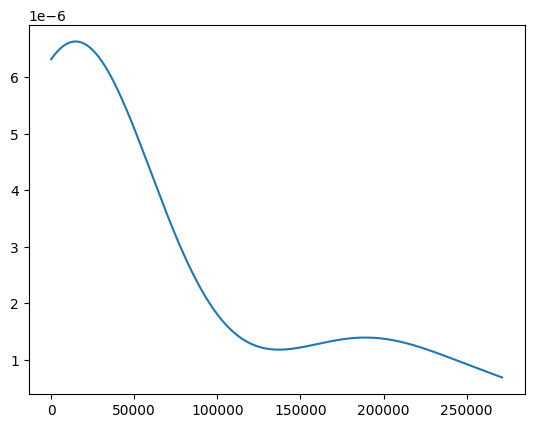

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

kde = gaussian_kde(list(request_counts_of_day['timestamp']))

x = np.linspace(request_counts_of_day['timestamp'].min(), request_counts_of_day['timestamp'].max(),1000)
y = kde.pdf(x)

plt.plot(x, y)
plt.show()

In [148]:
from scipy.optimize import minimize_scalar
result = minimize_scalar(kde.pdf, bounds=(request_counts_of_day['timestamp'].min(), request_counts_of_day['timestamp'].max()))
print(result.fun)
print(result.x)

[1.178333e-06]
[137020.83001062]


### Đánh giá 
 * Lựa chọn tần suất xuất hiện với số lượng request là 16 
 
 * Vì chỉ số PDF tăng điều này chứng tỏ rằng xác suất giá trị của biến ngẫu nhiên đó tại một thời điểm cụ thể trên trục giá trị tăng lên

 * PDF: càng cao thì xác suất xảy ra tại biến ngẫu nhiên rơi vào khoảng giá trị xung quanh điểm đó

 * CDF: là giá trị hàm phân phối tích lũy tại giá trị x nào đó đang tăng đần, thì xác suất để biến ngẫu nhiên nhỏ hơn hoặc bằng giá trị đó cũng tăng dần.

 => Tức là với số lượng request trên 16 là nhứng ngày đó là ngày bất thường
 

Lower threshold: -58094.850000000006, 
Upper threshold: 111532.35



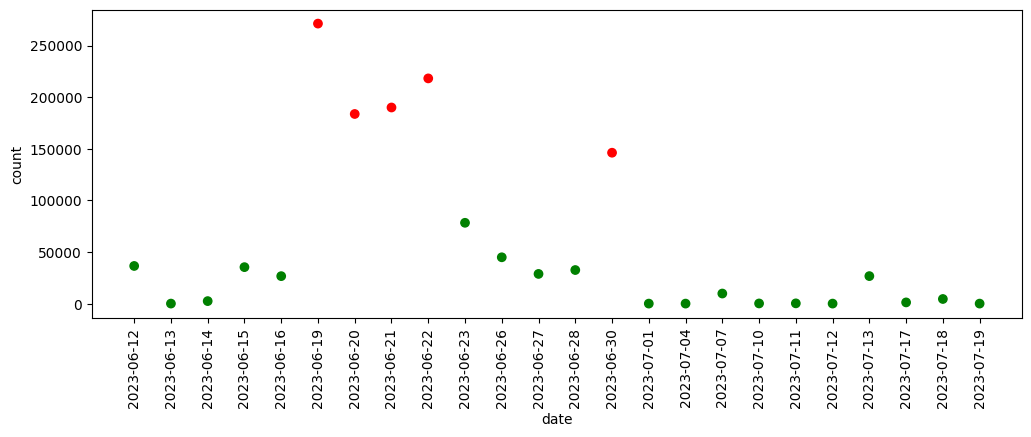

          date   count  Predictions
0   2023-06-12   36467            1
1   2023-06-13      16            1
2   2023-06-14    2425            1
3   2023-06-15   35323            1
4   2023-06-16   26602            1
5   2023-06-19  271276           -1
6   2023-06-20  183708           -1
7   2023-06-21  189996           -1
8   2023-06-22  218187           -1
9   2023-06-23   78288           -1
10  2023-06-26   44868           -1
11  2023-06-27   28751            1
12  2023-06-28   32524            1
13  2023-06-30  146177           -1
14  2023-07-01       1            1
15  2023-07-04       1            1
16  2023-07-07    9757           -1
17  2023-07-10     147            1
18  2023-07-11     237            1
19  2023-07-12       8            1
20  2023-07-13   26643            1
21  2023-07-17    1158            1
22  2023-07-18    4468            1
23  2023-07-19       1            1


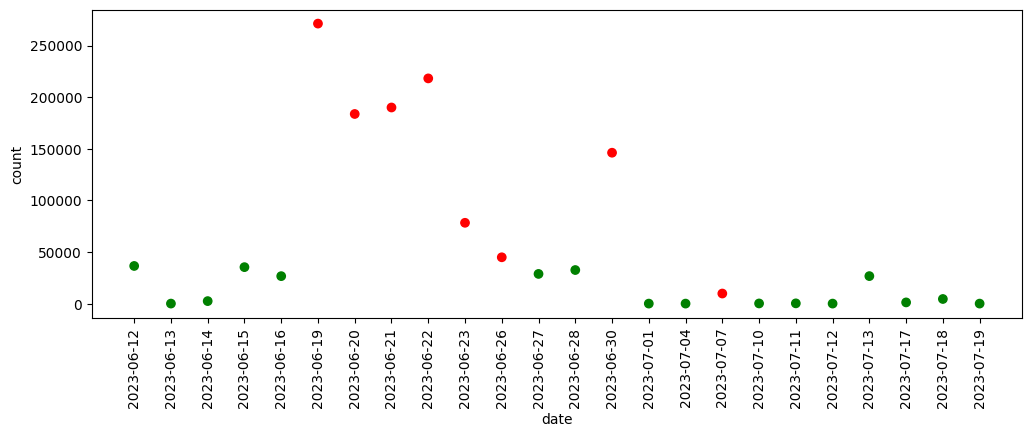

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


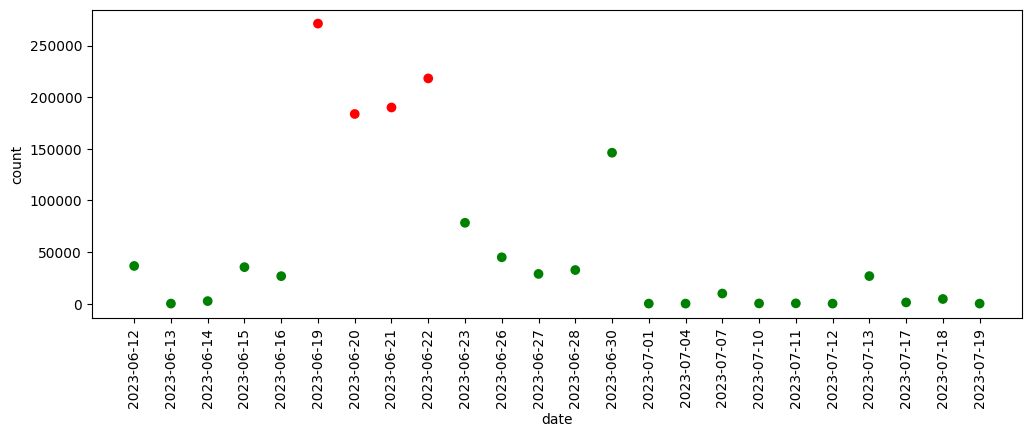

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


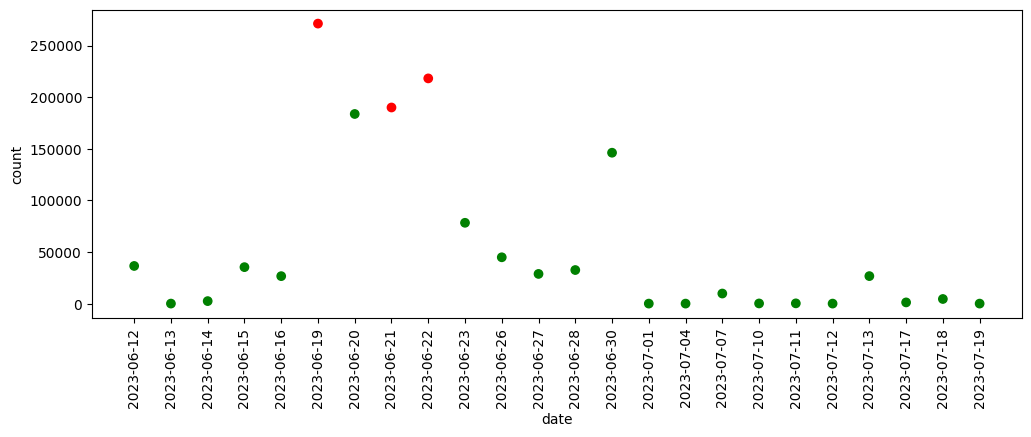

In [149]:
import numpy as np
import pandas as pd
from pyod.models.mad import MAD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


data['date'] = data['time_stamp'].dt.strftime('%Y-%m-%d')
data = data.groupby(['date']).size().reset_index(name='count')


def fit_model(model, data, column='count'):
    # fit the model and predict it
    df = data.copy()
    data_to_predict = data[column].to_numpy().reshape(-1, 1)
    predictions = model.fit_predict(data_to_predict)
    df['Predictions'] = predictions
    
    return df

def plot_anomalies(df, x='date', y='count'):

    # categories will be having values from 0 to n
    # for each values in 0 to n it is mapped in colormap
    categories = df['Predictions'].to_numpy()
    colormap = np.array(['g', 'r'])

    f = plt.figure(figsize=(12, 4))
    f = plt.scatter(df[x], df[y], c=colormap[categories])
    f = plt.xlabel(x)
    f = plt.ylabel(y)
    f = plt.xticks(rotation=90)
    plt.show()

def find_anomalies(value, lower_threshold, upper_threshold):
    
    if value < lower_threshold or value > upper_threshold:
        return 1
    else: return 0

def iqr_anomaly_detector(data, column='count', threshold=1.1):
    
    df = data.copy()
    quartiles = dict(data[column].quantile([.25, .50, .75]))
    quartile_3, quartile_1 = quartiles[0.75], quartiles[0.25]
    iqr = quartile_3 - quartile_1

    lower_threshold = quartile_1 - (threshold * iqr)
    upper_threshold = quartile_3 + (threshold * iqr)

    print(f"Lower threshold: {lower_threshold}, \nUpper threshold: {upper_threshold}\n")
    
    df['Predictions'] = data[column].apply(find_anomalies, args=(lower_threshold, upper_threshold))
    return df

iqr_df = iqr_anomaly_detector(data)
plot_anomalies(iqr_df)

iso_forest = IsolationForest(n_estimators=100)
iso_df = fit_model(iso_forest, data)
print(iso_df)
iso_df['Predictions'] = iso_df['Predictions'].map(lambda x: 1 if x==-1 else 0)
plot_anomalies(iso_df)


mad_model = MAD()
mad_df = fit_model(mad_model, data)
plot_anomalies(mad_df)


knn_model = KNN()
knn_df = fit_model(knn_model, data)
plot_anomalies(knn_df)